In [1]:
import kagglehub
import torch
from PIL import Image
from torchvision import transforms
import numpy as np
import os
from IPython.display import display
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader
import random
from sklearn.model_selection import train_test_split

from utils import load_images


/Users/keerthireddy/Documents/rc/mushrooms/.mushroomvenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Explore data

In [ ]:
# base_dir = kagglehub.dataset_download("maysee/mushrooms-classification-common-genuss-images")
# print("Path to dataset files:", path)
base_dir = "/Users/keerthireddy/.cache/kagglehub/datasets/maysee/mushrooms-classification-common-genuss-images/versions/1/Mushrooms"
images = load_images(base_dir)

In [ ]:
# what's a good size for the images?
sizes = [row["image"].size for row in images]
widths, heights = zip(*sizes)

plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, alpha=0.5)
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.title('Image Dimensions Distribution')

# Add a line for square images (y=x) for reference
min_dim = min(min(widths), min(heights))
max_dim = max(max(widths), max(heights))
plt.plot([min_dim, max_dim], [min_dim, max_dim], 'r--', alpha=0.5, label='Square (1:1)')

z = np.polyfit(widths, heights, 1)  # 1 for linear fit
p = np.poly1d(z)
plt.plot(widths, p(widths), 'g-', alpha=0.5, label=f'Best fit (y = {z[0]:.2f}x + {z[1]:.2f})')


plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# compared with resize and center crop as square vs as rectangle (.6:1) as that's the most common shape
# square seems to capture enough mushroom 
# transform some images and look through them to see if this is a reasonable option or if we lose too much info
# transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(150), transforms.CenterCrop((90, 150))])
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(224), transforms.CenterCrop((224,224))])

for data in images[200:200+15]:
    display(data["image"])
    tensor = transform(data["image"])
    img = F.to_pil_image(tensor)
    display(img)

# square seems fine - we can adjust size up or down depending on how things go 

In [ ]:
# how many images are RGB?
sum([1 for data in images if data["image"].mode == "RGB"])/len(images)
# vast majority, so made RBG only it the default in load_images to drop others
# note that now this will show up as 100%

# Test Model & Explore Data

In [2]:
import random
import torch
from utils import create_data_lists, make_dataloader
from cnn import MushroomClassifier
from trainer import MushroomTrainer

In [4]:
SEED = 81
random.seed(SEED)
torch.manual_seed(SEED)
base_dir = "/Users/keerthireddy/.cache/kagglehub/datasets/maysee/mushrooms-classification-common-genuss-images/versions/1/Mushrooms"

print("creating data lists")
train_data, val_data, test_data, labels = create_data_lists(base_dir)
num_classes = len({data["genus"] for data in train_data})

print("creating dataloaders")
# make dataloaders
val_dataloader = make_dataloader(val_data)
test_dataloader = make_dataloader(test_data)

print("making neural net and trainer")

shroom_classifier = MushroomClassifier(num_classes)
shroom_trainer = MushroomTrainer(
    shroom_classifier,
    train_data,
    val_dataloader,
    test_dataloader,
    num_epochs=15,
    seed=SEED,
    labels=labels
)

checkpoint = shroom_trainer.load_checkpoint("./models/model_2/epoch_10.pth", seed=SEED)

loading checkpoint ./models/model_2/epoch_10.pth


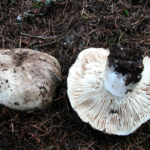

Agaricus: 47.81845474243164
Amanita: 31.951507568359375
Boletus: 1.5852861404418945
Cortinarius: 1.3793119192123413
Entoloma: 0.6189728379249573
Hygrocybe: 0.13735708594322205
Lactarius: 7.164891719818115
Russula: 8.504709243774414
Suillus: 0.8395065665245056
Target: 7, Russula


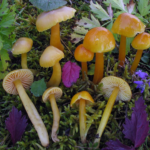

Agaricus: 0.0003211256698705256
Amanita: 0.003836660413071513
Boletus: 3.398644912522286e-05
Cortinarius: 0.14796383678913116
Entoloma: 0.8516449332237244
Hygrocybe: 98.95864868164062
Lactarius: 0.01417867187410593
Russula: 0.0017529816832393408
Suillus: 0.021616695448756218
Target: 5, Hygrocybe


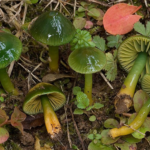

Agaricus: 1.3409732580184937
Amanita: 2.343921422958374
Boletus: 3.1612768173217773
Cortinarius: 19.85641098022461
Entoloma: 19.359737396240234
Hygrocybe: 15.243369102478027
Lactarius: 17.921131134033203
Russula: 5.713644504547119
Suillus: 15.059536933898926
Target: 5, Hygrocybe


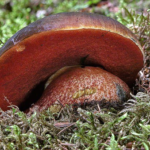

Agaricus: 0.0013265452580526471
Amanita: 0.0073810662142932415
Boletus: 96.52494049072266
Cortinarius: 1.857862114906311
Entoloma: 0.0013184103881940246
Hygrocybe: 0.003638800699263811
Lactarius: 0.23407447338104248
Russula: 0.09780623018741608
Suillus: 1.2716357707977295
Target: 2, Boletus


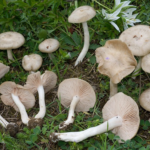

Agaricus: 1.1545794010162354
Amanita: 0.8642787933349609
Boletus: 0.01820959523320198
Cortinarius: 0.03743446245789528
Entoloma: 95.30183410644531
Hygrocybe: 1.4545797109603882
Lactarius: 0.7512339353561401
Russula: 0.31475886702537537
Suillus: 0.10308098047971725
Target: 4, Entoloma


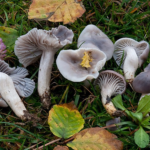

Agaricus: 1.5669481754302979
Amanita: 3.3856847286224365
Boletus: 0.5399612784385681
Cortinarius: 17.001989364624023
Entoloma: 42.232177734375
Hygrocybe: 13.919580459594727
Lactarius: 15.03180980682373
Russula: 4.368855953216553
Suillus: 1.9529916048049927
Target: 5, Hygrocybe


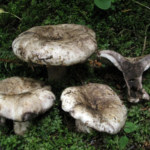

Agaricus: 16.00305938720703
Amanita: 14.417841911315918
Boletus: 1.5027499198913574
Cortinarius: 1.5864386558532715
Entoloma: 29.108089447021484
Hygrocybe: 1.5166348218917847
Lactarius: 21.48567771911621
Russula: 11.875855445861816
Suillus: 2.5036561489105225
Target: 7, Russula


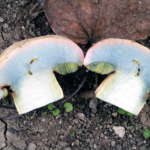

Agaricus: 10.104434967041016
Amanita: 0.1660708785057068
Boletus: 56.8166389465332
Cortinarius: 5.675371170043945
Entoloma: 0.01948040910065174
Hygrocybe: 0.016777219250798225
Lactarius: 11.27743911743164
Russula: 9.096364974975586
Suillus: 6.8274312019348145
Target: 2, Boletus


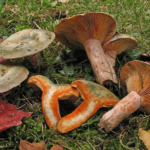

Agaricus: 0.002995180431753397
Amanita: 0.0592593215405941
Boletus: 0.02968921698629856
Cortinarius: 1.143841028213501
Entoloma: 0.0025138691999018192
Hygrocybe: 0.0852244421839714
Lactarius: 96.4242935180664
Russula: 1.227889895439148
Suillus: 1.0242838859558105
Target: 6, Lactarius


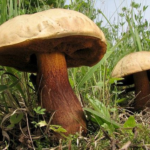

Agaricus: 0.008094274438917637
Amanita: 0.014363879337906837
Boletus: 95.3025894165039
Cortinarius: 1.2907732725143433
Entoloma: 0.001254218746908009
Hygrocybe: 0.0023198933340609074
Lactarius: 1.9276665449142456
Russula: 0.020438741892576218
Suillus: 1.4325041770935059
Target: 2, Boletus


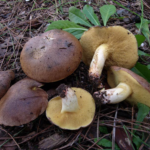

Agaricus: 0.005530566908419132
Amanita: 0.0633997693657875
Boletus: 9.911084175109863
Cortinarius: 5.436939239501953
Entoloma: 0.40200096368789673
Hygrocybe: 0.12141960859298706
Lactarius: 54.967044830322266
Russula: 6.023035049438477
Suillus: 23.069541931152344
Target: 8, Suillus


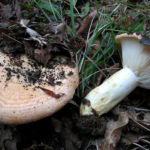

Agaricus: 20.65895652770996
Amanita: 5.609293460845947
Boletus: 2.1207025051116943
Cortinarius: 5.507774829864502
Entoloma: 9.56801700592041
Hygrocybe: 0.8285456299781799
Lactarius: 20.502288818359375
Russula: 19.464000701904297
Suillus: 15.7404203414917
Target: 6, Lactarius


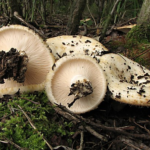

Agaricus: 1.2257202863693237
Amanita: 12.074066162109375
Boletus: 2.0040056705474854
Cortinarius: 0.10719425976276398
Entoloma: 0.4224889576435089
Hygrocybe: 0.48341336846351624
Lactarius: 68.35749816894531
Russula: 12.186200141906738
Suillus: 3.1394057273864746
Target: 6, Lactarius


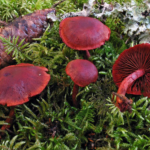

Agaricus: 0.02062923088669777
Amanita: 0.00022912588610779494
Boletus: 0.601136326789856
Cortinarius: 84.40655517578125
Entoloma: 0.001066139666363597
Hygrocybe: 0.040484897792339325
Lactarius: 8.25700569152832
Russula: 6.507918357849121
Suillus: 0.16496750712394714
Target: 3, Cortinarius


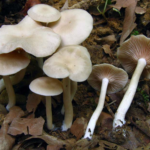

Agaricus: 17.34986686706543
Amanita: 5.0652971267700195
Boletus: 0.006457532290369272
Cortinarius: 18.786043167114258
Entoloma: 57.29618835449219
Hygrocybe: 0.4995884299278259
Lactarius: 0.43300437927246094
Russula: 0.05816248059272766
Suillus: 0.5053964853286743
Target: 4, Entoloma


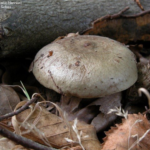

Agaricus: 7.967345237731934
Amanita: 1.2280049324035645
Boletus: 12.020228385925293
Cortinarius: 5.422401428222656
Entoloma: 6.975578308105469
Hygrocybe: 0.08392617851495743
Lactarius: 40.95536422729492
Russula: 18.628803253173828
Suillus: 6.718353748321533
Target: 6, Lactarius


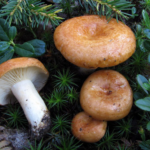

Agaricus: 0.0027467580512166023
Amanita: 0.40842586755752563
Boletus: 0.03226177766919136
Cortinarius: 0.32662540674209595
Entoloma: 0.013837585225701332
Hygrocybe: 0.0483621247112751
Lactarius: 11.69651985168457
Russula: 78.67947387695312
Suillus: 8.791747093200684
Target: 6, Lactarius


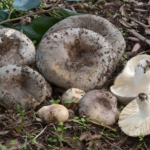

Agaricus: 25.714618682861328
Amanita: 15.230112075805664
Boletus: 1.1077748537063599
Cortinarius: 6.073513984680176
Entoloma: 7.405359268188477
Hygrocybe: 0.7178754210472107
Lactarius: 16.926578521728516
Russula: 24.788850784301758
Suillus: 2.0353240966796875
Target: 7, Russula


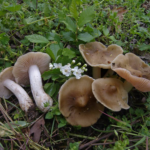

Agaricus: 0.47825929522514343
Amanita: 4.571424961090088
Boletus: 0.16877323389053345
Cortinarius: 20.191234588623047
Entoloma: 42.619327545166016
Hygrocybe: 1.1587523221969604
Lactarius: 18.91399383544922
Russula: 1.5532715320587158
Suillus: 10.344966888427734
Target: 4, Entoloma


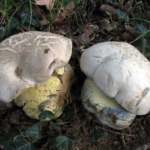

Agaricus: 2.0536961555480957
Amanita: 72.86670684814453
Boletus: 12.055893898010254
Cortinarius: 0.7013178467750549
Entoloma: 0.19394443929195404
Hygrocybe: 0.10179440677165985
Lactarius: 2.662078619003296
Russula: 8.191549301147461
Suillus: 1.1730070114135742
Target: 2, Boletus


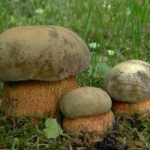

Agaricus: 0.009240205399692059
Amanita: 0.16442275047302246
Boletus: 98.35661315917969
Cortinarius: 0.5666974782943726
Entoloma: 0.07528752088546753
Hygrocybe: 0.004466324578970671
Lactarius: 0.4201962649822235
Russula: 0.2666984796524048
Suillus: 0.13638100028038025
Target: 2, Boletus


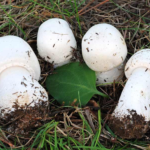

Agaricus: 62.6059455871582
Amanita: 34.70111083984375
Boletus: 1.1698862314224243
Cortinarius: 0.4273829460144043
Entoloma: 0.028520386666059494
Hygrocybe: 0.005954152438789606
Lactarius: 0.25186043977737427
Russula: 0.661048173904419
Suillus: 0.1482938677072525
Target: 0, Agaricus


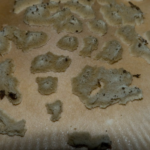

Agaricus: 3.736231803894043
Amanita: 14.061286926269531
Boletus: 14.859573364257812
Cortinarius: 4.901869297027588
Entoloma: 9.019309997558594
Hygrocybe: 0.7301580309867859
Lactarius: 26.676315307617188
Russula: 23.85808753967285
Suillus: 2.1571638584136963
Target: 1, Amanita


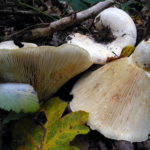

Agaricus: 22.09317970275879
Amanita: 1.316409707069397
Boletus: 3.557426929473877
Cortinarius: 2.2248294353485107
Entoloma: 28.66361427307129
Hygrocybe: 1.0367125272750854
Lactarius: 24.710023880004883
Russula: 13.657782554626465
Suillus: 2.7400152683258057
Target: 6, Lactarius


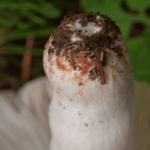

Agaricus: 7.089704990386963
Amanita: 10.472213745117188
Boletus: 1.499954104423523
Cortinarius: 4.690389633178711
Entoloma: 9.667803764343262
Hygrocybe: 0.9686535000801086
Lactarius: 14.240715026855469
Russula: 50.15963363647461
Suillus: 1.210930347442627
Target: 7, Russula


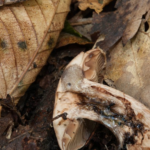

Agaricus: 1.4341710805892944
Amanita: 5.597846031188965
Boletus: 0.9337887167930603
Cortinarius: 18.467037200927734
Entoloma: 27.61402130126953
Hygrocybe: 0.23745965957641602
Lactarius: 30.621280670166016
Russula: 8.345773696899414
Suillus: 6.748628616333008
Target: 3, Cortinarius


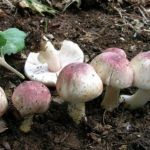

Agaricus: 10.96733283996582
Amanita: 0.3105376362800598
Boletus: 43.89064407348633
Cortinarius: 0.6136235594749451
Entoloma: 0.0030775051563978195
Hygrocybe: 0.08662432432174683
Lactarius: 5.157167911529541
Russula: 38.478065490722656
Suillus: 0.4929296672344208
Target: 0, Agaricus


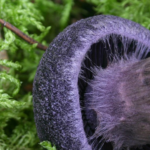

Agaricus: 0.004663212690502405
Amanita: 0.0007347189239226282
Boletus: 0.000316134886816144
Cortinarius: 63.70459747314453
Entoloma: 23.475160598754883
Hygrocybe: 4.195714950561523
Lactarius: 8.54175090789795
Russula: 0.011550999246537685
Suillus: 0.06551273167133331
Target: 3, Cortinarius


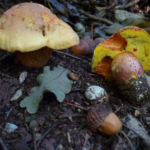

Agaricus: 0.40983134508132935
Amanita: 0.199021115899086
Boletus: 11.020776748657227
Cortinarius: 21.8023738861084
Entoloma: 16.46438217163086
Hygrocybe: 4.5238165855407715
Lactarius: 13.594883918762207
Russula: 4.609399795532227
Suillus: 27.375507354736328
Target: 2, Boletus


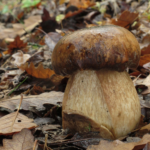

Agaricus: 0.04362773522734642
Amanita: 0.03740721195936203
Boletus: 96.28118133544922
Cortinarius: 1.1945624351501465
Entoloma: 0.026161756366491318
Hygrocybe: 0.0006459374562837183
Lactarius: 1.0997658967971802
Russula: 0.696843147277832
Suillus: 0.6198108792304993
Target: 2, Boletus


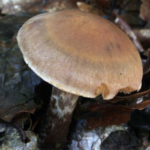

Agaricus: 2.4223880767822266
Amanita: 3.3056271076202393
Boletus: 1.730327844619751
Cortinarius: 3.3251237869262695
Entoloma: 65.34825897216797
Hygrocybe: 0.6422796845436096
Lactarius: 18.903215408325195
Russula: 2.360968589782715
Suillus: 1.9618057012557983
Target: 3, Cortinarius


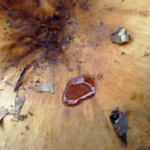

Agaricus: 0.3420768976211548
Amanita: 0.8747523427009583
Boletus: 34.33415985107422
Cortinarius: 9.791999816894531
Entoloma: 0.27792850136756897
Hygrocybe: 0.24723125994205475
Lactarius: 27.210954666137695
Russula: 21.19169807434082
Suillus: 5.729204177856445
Target: 7, Russula


In [14]:
num_to_test = 32
inputs, targets = next(iter(test_dataloader))[:num_to_test]
shroom_trainer.model.eval()
with torch.no_grad():
    preds = shroom_trainer.model.forward(inputs)
    loss = shroom_trainer.loss_fn(preds, targets)
shroom_trainer.model.train()
probs = torch.softmax(preds, dim=1)
for i, data in enumerate(inputs):
    img = F.to_pil_image(data)
    display(img)
    for j, prob in enumerate(probs[i]):
        print(f"{labels[j]}: {prob*100}")
    print(f"Target: {targets[i]}, {labels[targets[i]]}")